# 1. Import the data

In [ ]:
 ! pip install -q kaggle

In [ ]:
 from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [04:02<00:00, 23.5MB/s]
100% 5.20G/5.20G [04:02<00:00, 23.0MB/s]


In [ ]:
from zipfile import ZipFile
filename="/content/skin-cancer-mnist-ham10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")

done


# 2. Preparing the Data

In [ ]:
import os

def move_images(source_dir, destination_dir):
    """Moves all images from a source directory to a destination directory.

    Args:
        source_dir: The source directory containing the images to be moved.
        destination_dir: The destination directory where the images should be moved.
    """

    # Get a list of all files in the source directory.
    files = os.listdir(source_dir)

    # Iterate over the files in the source directory.
    for file in files:
        # Check if the file is an image.
        if file.endswith(".jpg") or file.endswith(".png"):
            # Create a path to the source image file.
            source_image_path = os.path.join(source_dir, file)

            # Create a path to the destination image file.
            destination_image_path = os.path.join(destination_dir, file)

            # Move the image file from the source directory to the destination directory.
            os.rename(source_image_path, destination_image_path)



In [ ]:
# Get the path to the HAM100000 images directory.
ham_100000_images_dir = "/content/HAM10000images"

# Iterate over all the subdirectories in the current directory.
for subdir in os.listdir("/content/"):
    # Check if the subdirectory is a directory.
    if os.path.isdir(subdir):
        # Create a path to the subdirectory.
        subdir_path = os.path.join("/content/", subdir)

        # Move all the images in the subdirectory to the HAM100000 images directory.
        move_images(subdir_path, ham_100000_images_dir)

In [ ]:
len(os.listdir("/content/HAM10000images"))

10015

# 3. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 4. Data Analysis

In [2]:
data_pd = pd.read_csv('./dataset/HAM10000/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [3]:
base_path = "./dataset/HAM10000"
train_dir = os.path.join(base_path, 'train_dir')
test_dir = os.path.join(base_path, 'test_dir')

In [4]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization,dataset
lesion_id,,,,,,,
HAM_0000000,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1


In [5]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [6]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates


In [7]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [8]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'], random_state=42)

In [9]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,duplicates,train


In [10]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,is_duplicate
4966,HAM_0001445,ISIC_0029433,nv,follow_up,35.0,male,trunk,vidir_molemax,no
9184,HAM_0006105,ISIC_0032236,nv,histo,40.0,female,foot,rosendahl,no
9558,HAM_0004212,ISIC_0034114,nv,consensus,40.0,female,unknown,vidir_modern,no
5784,HAM_0002063,ISIC_0024819,nv,follow_up,70.0,female,lower extremity,vidir_molemax,no
6290,HAM_0001750,ISIC_0028832,nv,follow_up,55.0,male,trunk,vidir_molemax,no


In [11]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [12]:
len(test_list)

828

In [13]:
len(train_list)

9187

In [14]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

### 4.1 data shaping

In [ ]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [ ]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    source = os.path.join(base_path, file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [ ]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    source = os.path.join(base_path, file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

# 5. Data Augmantion

In [ ]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('/content/HAM10000images/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('/content/HAM10000images/train_dir/' + img_class, file_name)

        # creating a target directory to send images
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = '/content/HAM10000images/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(299, 299),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory
    shutil.rmtree('aug_dir')

Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [ ]:
def delete_images_in_directory(directory_path):
    image_extensions = (".jpg", ".jpeg", ".png")
    count = 0
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        if os.path.isfile(file_path) and file.lower().endswith(image_extensions):
            os.remove(file_path)
            count+=1
    print(f"Done {count}")

directory_path = "/content/HAM10000images"
delete_images_in_directory(directory_path)

Done 10015


# 6. Save the data on drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r "/content/HAM10000images" "/tmp/HAM10000images"

In [ ]:
!mv "/tmp/HAM10000images" "/content/drive/MyDrive"

# 7. Model

In [ ]:
!cp -r "/content/drive/MyDrive/HAM10000images" "/content/HAM10000images"

In [15]:
train_path = './dataset/HAM10000+AUG/train_dir'
test_path = './dataset/HAM10000+AUG/test_dir'
batch_size=16

In [16]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [17]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 


Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


## 7.1 fine tune the Inception Res Net V2 model

In [18]:
irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Excluding the last (30 v1 28 v2) layers of the model. (v3 == retrain 20 layer)
conv = irv2.layers[-28].output

In [19]:
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
output = Flatten()(conv)

output = Dense(512, activation='relu')(output)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [20]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [21]:
class_weights = {
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }


checkpoint=  ModelCheckpoint(filepath = '/content/drive/MyDrive/HAM1000+AUG+IRV2+V2.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=20, min_delta=0.001)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
                    epochs=70,
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size,callbacks=[checkpoint,Earlystop,learning_rate_reduction],class_weight=class_weights)

Epoch 1/70
918/918 [==============================] - 636s 593ms/step - loss: 1.6172 - accuracy: 0.5285 - val_loss: 0.6831 - val_accuracy: 0.7258 - lr: 0.0100
Epoch 2/70
918/918 [==============================] - 546s 594ms/step - loss: 1.2669 - accuracy: 0.6330 - val_loss: 0.5109 - val_accuracy: 0.8164 - lr: 0.0100
Epoch 3/70
918/918 [==============================] - 537s 585ms/step - loss: 1.0825 - accuracy: 0.6849 - val_loss: 0.5912 - val_accuracy: 0.7923 - lr: 0.0100
Epoch 4/70
918/918 [==============================] - 545s 594ms/step - loss: 0.9553 - accuracy: 0.7269 - val_loss: 0.6821 - val_accuracy: 0.7162 - lr: 0.0100
Epoch 5/70
918/918 [==============================] - 549s 597ms/step - loss: 0.8197 - accuracy: 0.7588 - val_loss: 0.4659 - val_accuracy: 0.8684 - lr: 0.0100
Epoch 6/70
918/918 [==============================] - 541s 588ms/step - loss: 0.7780 - accuracy: 0.7795 - val_loss: 0.5216 - val_accuracy: 0.7983 - lr: 0.0100
Epoch 7/70
918/918 [==========================

### continue the traning

In [ ]:
# Import necessary libraries and load your model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load your model from the saved HDF5 file
model = load_model('/content/drive/MyDrive/HAM1000+AUG+IRV2+V2.hdf5')

# Compile the model with the same optimizer and loss function
opt1 = Adam(learning_rate=0.0025, epsilon=0.1)  # Make sure to use the same optimizer settings
model.compile(optimizer=opt1, loss='categorical_crossentropy', metrics=['accuracy'])

# Set the initial epoch to continue training from where you left off
initial_epoch = 21  # Update this with the last completed epoch + 1

# Continue training from the specified initial epoch
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df) / 10),
                    epochs=70,  # Adjust the total number of epochs as needed
                    validation_data=test_batches,
                    validation_steps=len(test_df) / batch_size,
                    callbacks=[checkpoint, Earlystop, learning_rate_reduction],
                    class_weight=class_weights,
                    initial_epoch=initial_epoch)

In [22]:
from tensorflow.keras import models
model.load_weights("./modelsHDF5/HAM1000+AUG+IRV2+V2.hdf5")

In [23]:
model.evaluate(test_batches, steps=len(test_df)/batch_size)

51/51 [==============================] - 149s 3s/step - loss: 0.1045 - accuracy: 0.9614


[0.10446864366531372, 0.9613526463508606]

In [34]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size)

51/51 [==============================] - 121s 2s/step


In [35]:
#geting predictions on test dataset
from tensorflow.keras.utils import to_categorical
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.91      0.87      0.89        23
         bcc       0.93      0.96      0.94        26
         bkl       0.95      0.86      0.90        66
          df       1.00      1.00      1.00         6
         mel       0.67      0.94      0.78        34
          nv       0.99      0.98      0.98       663
        vasc       1.00      0.80      0.89        10

    accuracy                           0.96       828
   macro avg       0.92      0.92      0.91       828
weighted avg       0.97      0.96      0.96       828



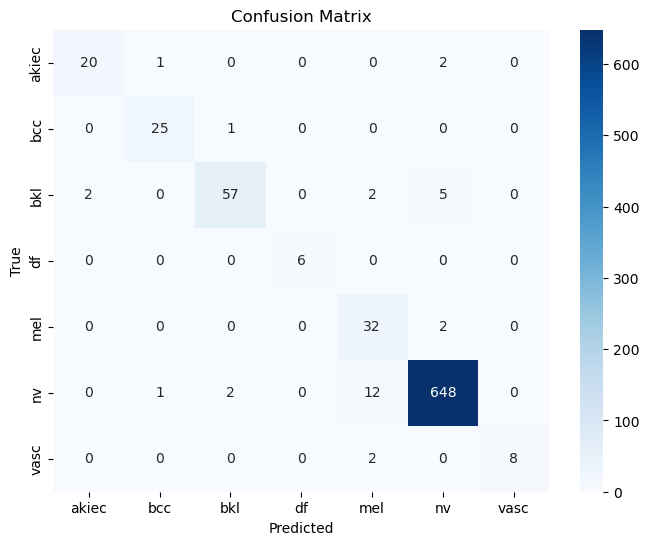

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

confusion_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Accuarcy in ISIC 2018
"""
test_ISIC2018 = datagen.flow_from_directory(
    "./dataset/ISIC2018_test/",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_ISIC2018)

"""

In [46]:
from PIL import Image

def predict_image_class(image_path, model):
    image = Image.open(image_path)

    image = image.resize((299, 299))  
    image = np.array(image)  
    image = image / 255.0 

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)

    class_label = np.argmax(predictions)

    class_names = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
    predicted_class = class_names[class_label]

    return predicted_class

1/1 [==============================] - 0s 228ms/step
Predicted Class: nv
